
Data types after cleaning:
Open     float64
High     float64
Low      float64
Close    float64
dtype: object

Null values after cleaning:
Open     0
High     0
Low      0
Close    0
dtype: int64

Data Sample:
                Open      High       Low     Close
date                                              
2025-02-05  43060.65  43250.75  42818.10  42888.30
2025-02-04  42642.75  42931.10  42407.35  42860.20
2025-02-03  41592.20  42375.25  41328.25  42314.25
2025-01-31  42586.10  42967.75  42486.80  42662.75
2025-01-30  42893.80  43025.85  42117.35  42426.65
Columns in DataFrame: ['Open', 'High', 'Low', 'Close']

Final feature types:
Open      float64
High      float64
Low       float64
SMA_10    float64
EMA_10    float64
RSI       float64
ATR       float64
dtype: object
Training BiLSTM...
Training CNN...
Training Random Forest...
Training XGBoost...
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Model Compariso

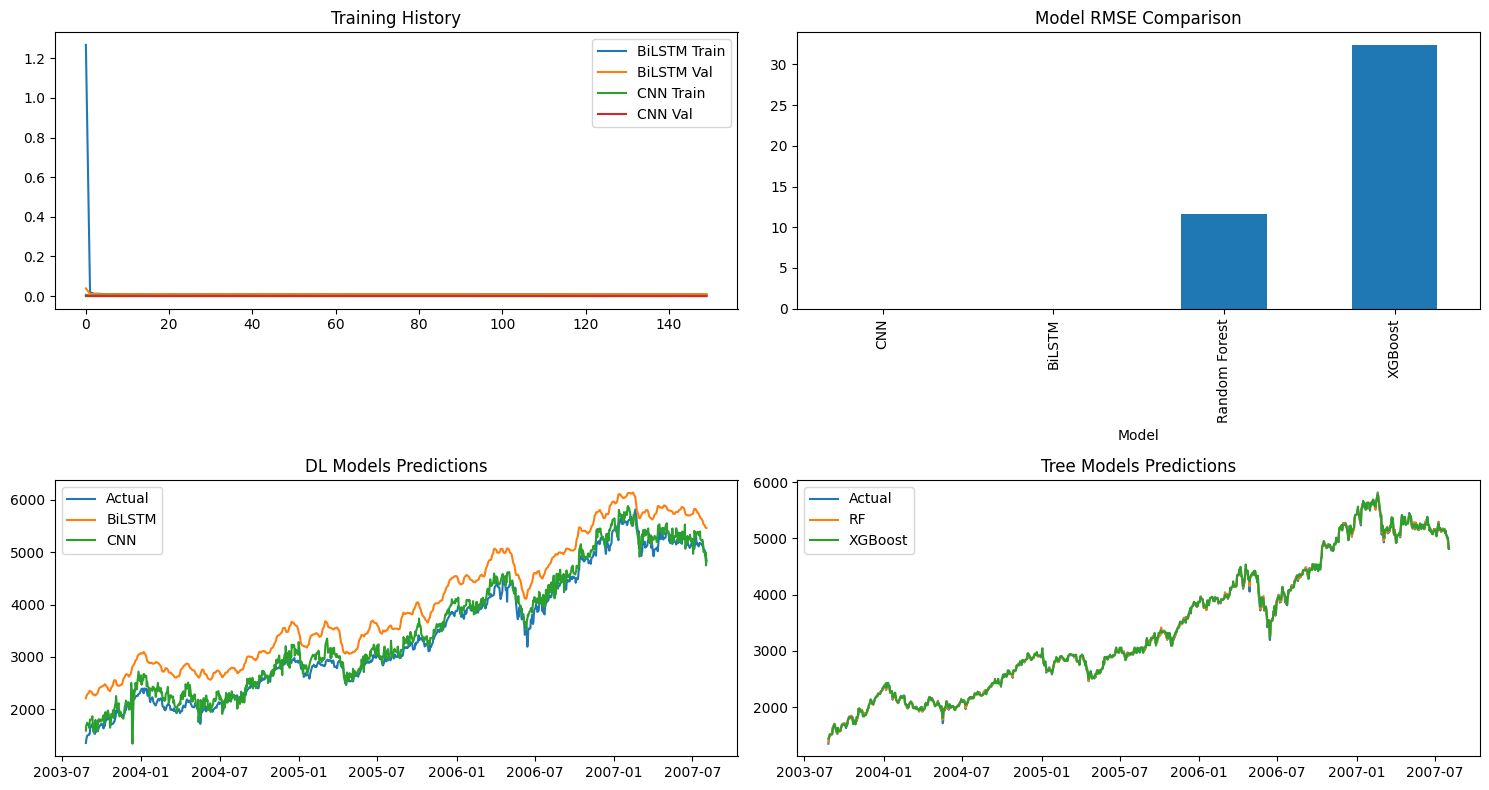

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 



Predictions and signals saved to stock_predictions_signals.csv
All models saved to disk


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from keras.models import Sequential, save_model
from keras.layers import Dense, Bidirectional, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.regularizers import L1L2
from keras.optimizers import Adam
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess data
def load_data(filepath):
    data = pd.read_csv(filepath)
       # Clean column names
    data.columns = data.columns.str.strip()  # Remove leading/trailing spaces
    data.columns = data.columns.str.replace(' ', '_')  # Replace spaces with underscores
    data["date"] = pd.to_datetime(data["Date"])
    data.set_index("date", inplace=True)
    data = data.drop("Date", axis=1)

    # Validate required columns
    required_cols = ['Open', 'High', 'Low', 'Close']
    missing = [col for col in required_cols if col not in data.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    # Robust numeric conversion
    for col in required_cols:
        # Remove all non-digit characters except dots and negatives
        data[col] = (
            data[col].astype(str)
            .str.replace(r'[^\d.-]', '', regex=True)  # Improved regex
            .replace(r'^\.$', np.nan, regex=True)  # Handle lone dots
            .replace('', np.nan)
        )
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Post-cleaning validation
    print("\nData types after cleaning:")
    print(data.dtypes)

    print("\nNull values after cleaning:")
    print(data.isna().sum())

    data.dropna(inplace=True)
    return data

data = load_data("/content/sample_data/Data/NIFTY_IT_Historical_Data.csv")
# Display sample
print("\nData Sample:")
print(data.head())
print("Columns in DataFrame:", data.columns.tolist())

# Technical Indicators
def add_technical_indicators(df):
    df = df.select_dtypes(include=np.number)  # In add_technical_indicators
    # # Validate numeric columns first
    # non_numeric = df.select_dtypes(exclude=np.number).columns
    # if not non_numeric.empty:
    #     raise ValueError(f"Non-numeric columns detected: {non_numeric.tolist()}")

    # Moving Averages
    df['SMA_10'] = df['Close'].rolling(10).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

    # RSI Calculation
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / (avg_loss + 1e-10)  # Avoid division by zero
    df['RSI'] = 100 - (100 / (1 + rs))

    # ATR Calculation
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = true_range.rolling(14).mean()

    return df.dropna()

data = add_technical_indicators(data)

# Prepare data
target = data[['Close']]
features = data.drop(['Close', 'Date'], axis=1, errors='ignore')
# Final type check
print("\nFinal feature types:")
print(features.dtypes)

# Scaling
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaled_features = scaler_x.fit_transform(features)
scaled_target = scaler_y.fit_transform(target)

# Sequence creation for DL models
def create_sequences(features, target, seq_length=30):
    X, y = [], []
    for i in range(seq_length, len(features)):
        X.append(features[i-seq_length:i])
        y.append(target[i])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(scaled_features, scaled_target)
train_size = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
y_train_seq, y_test_seq = y_seq[:train_size], y_seq[train_size:]

# Model Definitions
def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=L1L2(0.01, 0.01)), input_shape=input_shape),
        Dropout(0.4),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

def build_cnn(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

def train_rf(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def train_xgboost(X_train, y_train):
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    return model

# Prepare data for tree models
X_tree = features.iloc[30:]  # Match sequence length offset
y_tree = target.iloc[30:]

# Train models
print("Training BiLSTM...")
bilstm_model = build_bilstm((X_train_seq.shape[1], X_train_seq.shape[2]))
bilstm_history = bilstm_model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=32,
                                  validation_data=(X_test_seq, y_test_seq), verbose=0)

print("Training CNN...")
cnn_model = build_cnn((X_train_seq.shape[1], X_train_seq.shape[2]))
cnn_history = cnn_model.fit(X_train_seq, y_train_seq, epochs=150, batch_size=32,
                            validation_data=(X_test_seq, y_test_seq), verbose=0)

print("Training Random Forest...")
rf_model = train_rf(X_tree, y_tree.values.ravel())

print("Training XGBoost...")
xgb_model = train_xgboost(X_tree, y_tree.values.ravel())

# Evaluation functions
def evaluate_model(name, model, X_test, y_test, is_dl=False):
    if is_dl:
        pred = model.predict(X_test)
        if len(pred.shape) > 1: pred = pred.ravel()
    else:
        pred = model.predict(X_test)

    return {
        'Model': name,
        'MSE': mean_squared_error(y_test, pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, pred)),
        'MAE': mean_absolute_error(y_test, pred),
        'R2': r2_score(y_test, pred)
    }

# Evaluate all models
results = []

# DL Models
test_dates = data.index[30+train_size:]
dl_pred = bilstm_model.predict(X_test_seq)
results.append(evaluate_model('BiLSTM', bilstm_model, X_test_seq, y_test_seq, True))
results.append(evaluate_model('CNN', cnn_model, X_test_seq, y_test_seq, True))

# Tree Models
X_test_tree = X_tree.iloc[train_size:]
y_test_tree = y_tree.iloc[train_size:]
results.append(evaluate_model('Random Forest', rf_model, X_test_tree, y_test_tree))
results.append(evaluate_model('XGBoost', xgb_model, X_test_tree, y_test_tree))

# Results comparison
results_df = pd.DataFrame(results).set_index('Model')
print("\nModel Comparison:")
print(results_df.sort_values('RMSE'))

# Visualization
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(bilstm_history.history['loss'], label='BiLSTM Train')
plt.plot(bilstm_history.history['val_loss'], label='BiLSTM Val')
plt.plot(cnn_history.history['loss'], label='CNN Train')
plt.plot(cnn_history.history['val_loss'], label='CNN Val')
plt.title('Training History')
plt.legend()

plt.subplot(2, 2, 2)
results_df['RMSE'].sort_values().plot(kind='bar')
plt.title('Model RMSE Comparison')

plt.subplot(2, 2, 3)
actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))
plt.plot(test_dates, actual, label='Actual')
plt.plot(test_dates, scaler_y.inverse_transform(bilstm_model.predict(X_test_seq)), label='BiLSTM')
plt.plot(test_dates, scaler_y.inverse_transform(cnn_model.predict(X_test_seq)), label='CNN')
plt.title('DL Models Predictions')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(test_dates, actual, label='Actual')
plt.plot(test_dates, rf_model.predict(X_test_tree), label='RF')
plt.plot(test_dates, xgb_model.predict(X_test_tree), label='XGBoost')
plt.title('Tree Models Predictions')
plt.legend()

plt.tight_layout()
plt.show()

# Trading signals
def generate_signals(predictions, window=5):
    signals = []
    sma = pd.Series(predictions).rolling(window).mean()
    for i in range(len(predictions)):
        if i < window:
            signals.append('Hold')
        elif predictions[i] > sma[i] * 1.02:
            signals.append('Buy')
        elif predictions[i] < sma[i] * 0.98:
            signals.append('Sell')
        else:
            signals.append('Hold')
    return signals

# Generate predictions and signals
final_preds = {
    'Date': test_dates,
    'Actual': scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).ravel(),
    'BiLSTM': scaler_y.inverse_transform(bilstm_model.predict(X_test_seq).reshape(-1, 1)).ravel(),
    'CNN': scaler_y.inverse_transform(cnn_model.predict(X_test_seq).reshape(-1, 1)).ravel(),
    'RandomForest': rf_model.predict(X_test_tree),
    'XGBoost': xgb_model.predict(X_test_tree)
}

for model in ['BiLSTM', 'CNN', 'RandomForest', 'XGBoost']:
    final_preds[f'{model}_Signal'] = generate_signals(final_preds[model])

results_df = pd.DataFrame(final_preds)

# Save results and models
results_df.to_csv('stock_predictions_signals.csv', index=False)
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(xgb_model, 'xgboost_model.pkl')
save_model(bilstm_model, 'bilstm_model.h5')
save_model(cnn_model, 'cnn_model.h5')

print("\nPredictions and signals saved to stock_predictions_signals.csv")
print("All models saved to disk")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, LSTM, Input, Concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')

# Global configuration
plt.style.use('ggplot')
MARKET = 'INDIAN'  # Change to 'INDIAN' for Indian market and 'US' for American market

# Load and preprocess data
def load_data(market):
    if market == 'INDIAN':
        df = pd.read_csv("/content/sample_data/Data/merged.csv")
        # df = pd.read_csv("/content/sample_data/Data/NIFTY_IT_Historical_Data.csv")
        # Preprocessing steps for Indian market
        df.columns = df.columns.str.strip().str.replace(' ', '_')
        df["date"] = pd.to_datetime(df["Date"])
        df.set_index("date", inplace=True)
        df = df.drop("Date", axis=1)
         # Validate and clean columns
        required_cols = ['source_file','Open', 'High', 'Low', 'Close']
        for col in required_cols:
            df[col] = (df[col].astype(str)
                      .str.replace(r'[^\d.-]', '', regex=True)
                      .replace(r'^\.$', np.nan, regex=True)
                      .replace('', np.nan))
            # df[col] = pd.to_numeric(df[col], errors='coerce')

        # Add synthetic volume for demonstration
        df['Volume'] = np.random.randint(10000, 50000, size=len(df))
        df.dropna(inplace=True)
        return df
if __name__ == "__main__":
    # Load and preprocess data
    data = load_data(MARKET)
    # data = add_technical_indicators(data)

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

# Load merged data
merged_df = df

# Add a fallback mapping of features to market sectors
sector_mapping = {
    'Open': 'Price',
    'High': 'Price',
    'Low': 'Price',
    'Close': 'Price',
    'Volume': 'Volume',
    'SMA_10': 'Technical',
    'EMA_10': 'Technical',
    'RSI': 'Technical',
    'ATR': 'Technical',
    'Twitter_Sentiment': 'Social Media',
    'Reddit_Sentiment': 'Social Media',
    'Social_Volume': 'Social Media',
    # Add others as needed
}

# Identify feature columns (exclude target and identifiers)
feature_cols = merged_df.columns.difference(['source_file', 'Date', 'source_file_Date'])

# Group data by source_file
grouped = merged_df.groupby('source_file')

In [ ]:
df['source_file'].unique()

array(['VIX_History', 'NIFTY NEXT 50_Data', 'NIFTY 50_Data',
       'NIFTY PHARMA_Data', 'NIFTY FMCG_Data', 'NIFTY 100_Data',
       'NIFTY IT_Data', 'NIFTY HOUSING_Data',
       'NIFTY INDIA MANUFACTURING_Data', 'NIFTY BANK_Data',
       'NIFTY MIDCAP 100_Data', 'NIFTY INFRASTRUCTURE_Data',
       'NIFTY PSU BANK_Data', 'NIFTY ENERGY_Data', 'NIFTY AUTO_Data',
       'NIFTY MEDIA_Data', 'NIFTY METAL_Data', 'NIFTY COMMODITIES_Data',
       'INDIA VIX_minute', 'NIFTY PRIVATE BANK_Data',
       'NIFTY OIL  GAS_Data'], dtype=object)

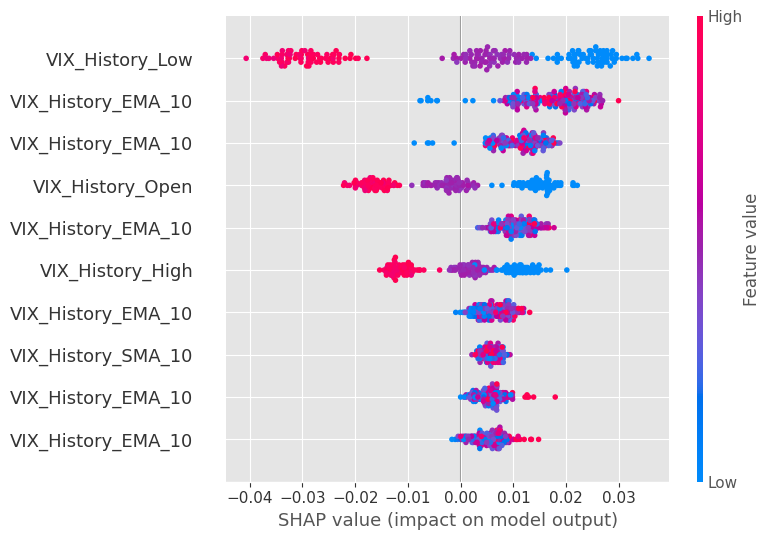

In [ ]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP explainer for tree models
explainer = shap.TreeExplainer(rf)

# Use a sample from test set to keep visualization manageable
X_sample = rf_features_test[:200]  # limit size for speed

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

# Summary plot
shap.summary_plot(shap_values, X_sample, feature_names=feature_names,max_display=10)


# shap.summary_plot(shap_values, X_sample, feature_names=feature_names)


Data shape after preprocessing: (803, 15)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Tweet', 'Stock_Name', 'Company_Name', 'Twitter_Sentiment', 'Reddit_Sentiment', 'Social_Volume', 'SMA_10', 'EMA_10', 'RSI', 'ATR']

Training hybrid model with social features...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.0908 - val_loss: 0.2537 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0257 - val_loss: 0.2779 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0210 - val_loss: 0.2608 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0175 - val_loss: 0.2131 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0193 - val_loss: 0.1916 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0147 - val_loss: 0.1832 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0160 -

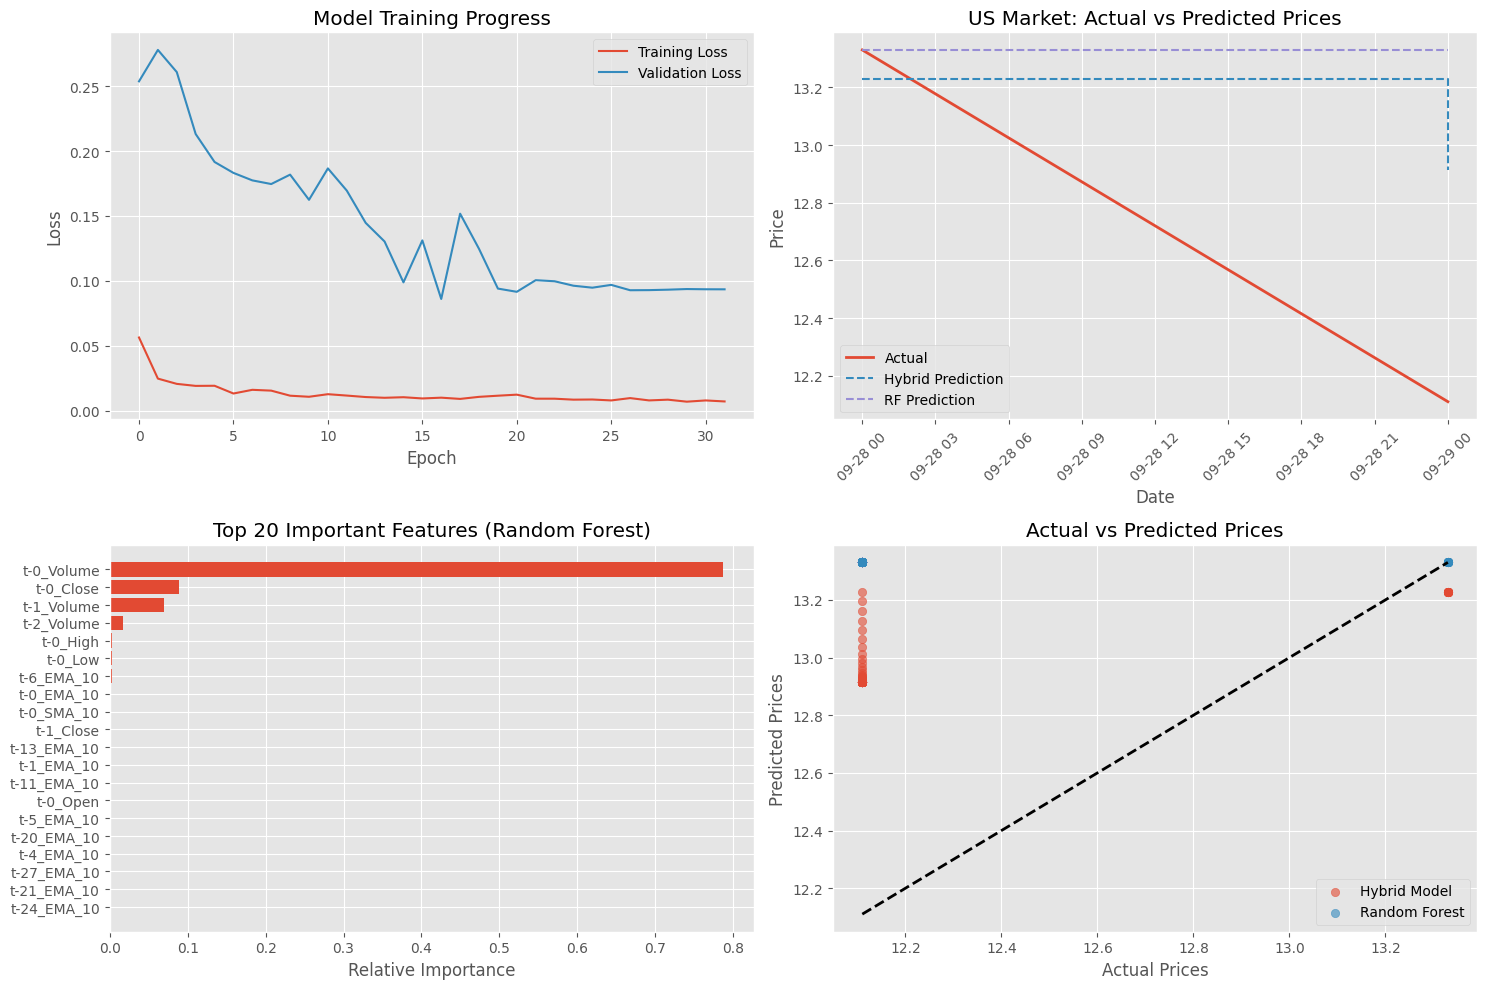


Models and scalers saved successfully!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

# Global configuration
plt.style.use('ggplot')
MARKET = 'US'  # Set to 'US' or 'INDIAN'
US_STOCK_FILE = "/content/sample_data/Data/stock_yfinance_data.csv"
US_SOCIAL_FILE = "/content/sample_data/Data/stock_tweets.csv"
INDIAN_FILE = "/content/sample_data/Data/NIFTY_IT_Historical_Data.csv"

# Load and preprocess data
def load_data(market):
    if market == 'INDIAN':
        # Load Indian market data
        df = pd.read_csv(INDIAN_FILE)

        # Preprocessing steps for Indian market
        df.columns = df.columns.str.strip().str.replace(' ', '_')
        df["date"] = pd.to_datetime(df["Date"])
        df.set_index("date", inplace=True)
        df = df.drop("Date", axis=1, errors='ignore')

        # Validate and clean columns
        required_cols = ['Open', 'High', 'Low', 'Close']
        for col in required_cols:
            df[col] = (df[col].astype(str)
                      .str.replace(r'[^\d.-]', '', regex=True)
                      .replace(r'^\.$', np.nan, regex=True)
                      .replace('', np.nan))
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Add synthetic volume if missing
        if 'Volume' not in df.columns:
            df['Volume'] = np.random.randint(10000, 50000, size=len(df))
        df.dropna(inplace=True)
        return df

    elif market == 'US':
        # Load US stock data
        #stock_df = pd.read_csv(US_STOCK_FILE)
        # Handle mixed date formats
        # 1. Verify file exists
        if not os.path.exists(US_STOCK_FILE):
          raise FileNotFoundError(f"Data file not found at: {US_STOCK_FILE}")

        # 2. Read CSV with error handling
        try:
           stock_df = pd.read_csv(US_STOCK_FILE)
        except Exception as e:
            raise IOError(f"Error reading {US_STOCK_FILE}: {str(e)}")

        # 3. Check if DataFrame is empty
        if stock_df.empty:
            raise ValueError(f"Loaded empty DataFrame from {US_STOCK_FILE}")

        # 4. Handle date parsing with better validation
        if 'Date' not in stock_df.columns:
            raise KeyError("CSV file is missing 'Date' column")

        stock_df['Date'] = pd.to_datetime(
            stock_df['Date'],
            errors='coerce',
            format='mixed',
            dayfirst=True
        )
        # 5. Handle failed date parsing
        date_failures = stock_df['Date'].isna().sum()
        if date_failures > 0:
            print(f"Warning: Failed to parse {date_failures} date values")
            stock_df = stock_df.dropna(subset=['Date'])

        # 6. Final validation before return
        if stock_df.empty:
            raise ValueError("All rows were dropped during date parsing")

        # 7. Sort by date for time-series operations
        stock_df = stock_df.sort_values('Date').reset_index(drop=True)
        # Remove rows with unparseable dates
        initial_count = len(stock_df)
        stock_df = stock_df.dropna(subset=['Date'])
        final_count = len(stock_df)

        if initial_count != final_count:
          print(f"Warning: Dropped {initial_count - final_count} rows with unparseable dates")
        stock_df['Date'] = pd.to_datetime(stock_df['Date'], format='%Y-%m-%d')
        stock_df.columns = stock_df.columns.str.strip().str.replace(' ', '_')
        stock_df["date"] = pd.to_datetime(stock_df["Date"], format='%d-%m-%Y')
        stock_df.set_index("date", inplace=True)
        stock_df = stock_df.drop(["Date", "Adj_Close", "Stock_Name"], axis=1, errors='ignore')

        # Load social media data
        social_df = pd.read_csv(US_SOCIAL_FILE)
        social_df['Date'] = social_df['Date'].str.split(pat = " ").str[0]
        social_df['Date'] = pd.to_datetime(social_df['Date'], format='%Y-%m-%d')
        social_df.columns = social_df.columns.str.strip().str.replace(' ', '_')
        social_df["date"] = pd.to_datetime(social_df["Date"])
        social_df.set_index("date", inplace=True)
        social_df = social_df.drop("Date", axis=1, errors='ignore')

        # Merge stock and social data
        df = pd.merge(stock_df, social_df, left_index=True, right_index=True, how='left')

        # Fill missing social data with zeros
        social_cols = ['Twitter_Sentiment', 'Reddit_Sentiment', 'Social_Volume']
        for col in social_cols:
            if col not in df.columns:
                df[col] = 0.0
            else:
                df[col].fillna(0, inplace=True)

        # Clean numerical columns
        for col in ['Open', 'High', 'Low', 'Close', 'Volume'] + social_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        df.dropna(inplace=True)
        return df

# Technical indicators
def add_technical_indicators(df):
    if df is None or df.empty:
        raise ValueError("Received invalid DataFrame in add_technical_indicators")
    # Moving Averages
    df['SMA_10'] = df['Close'].rolling(10).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

    # RSI
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))

    # ATR
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = true_range.rolling(14).mean()

    return df.dropna()

# FINESS Hybrid Model Architecture
def create_hybrid_model(tech_input_shape, social_input_shape=None):
    # Technical Feature Processor (Tech+)
    tech_input = Input(shape=tech_input_shape, name='tech_input')
    x = LSTM(128, return_sequences=True)(tech_input)
    x = LSTM(64, return_sequences=False)(x)
    tech_output = Dense(32, activation='relu')(x)

    # Social Feature Processor (FINESS) - Only for US market
    if social_input_shape is not None:
        social_input = Input(shape=social_input_shape, name='social_input')
        y = LSTM(64, return_sequences=False)(social_input)
        social_output = Dense(16, activation='relu')(y)

        # Combine technical and social features
        combined = Concatenate()([tech_output, social_output])
        z = Dense(64, activation='relu')(combined)
    else:
        z = tech_output

    # Final prediction layers
    z = Dense(32, activation='relu')(z)
    z = Dropout(0.3)(z)
    output = Dense(1)(z)

    # Create model
    if social_input_shape is not None:
        model = Model(inputs=[tech_input, social_input], outputs=output)
    else:
        model = Model(inputs=tech_input, outputs=output)

    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

# Create sequences for LSTM
def create_sequences(data, target_col, seq_length=30):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data.iloc[i-seq_length:i].values)
        y.append(data.iloc[i][target_col])
    return np.array(X), np.array(y)

# Inverse scaling function
def inverse_scale(scaler, values, feature_index):
    dummy = np.zeros((len(values), scaler.n_features_in_))
    dummy[:, feature_index] = values
    return scaler.inverse_transform(dummy)[:, feature_index]

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    data = load_data(MARKET)
    data = add_technical_indicators(data)
    print(f"Data shape after preprocessing: {data.shape}")
    print(f"Columns: {data.columns.tolist()}")

    # Prepare features based on market
    if MARKET == 'US':
        tech_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'EMA_10', 'RSI', 'ATR']
        social_features = ['Twitter_Sentiment', 'Reddit_Sentiment', 'Social_Volume']
        target = 'Close'
    else:  # Indian market
        tech_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'EMA_10', 'RSI', 'ATR']
        social_features = None
        target = 'Close'

    # Train-test split (time-based)
    train_size = int(0.8 * len(data))
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]

    # Scale data
    tech_scaler = MinMaxScaler()
    train_tech = tech_scaler.fit_transform(train_data[tech_features])
    test_tech = tech_scaler.transform(test_data[tech_features])

    if MARKET == 'US':
        social_scaler = MinMaxScaler()
        train_social = social_scaler.fit_transform(train_data[social_features])
        test_social = social_scaler.transform(test_data[social_features])

    # Create sequences
    seq_length = 30
    close_idx = tech_features.index('Close')  # Index of Close for inverse scaling

    X_train_tech, y_train = create_sequences(
        pd.DataFrame(train_tech, columns=tech_features),
        target_col=close_idx,
        seq_length=seq_length
    )

    X_test_tech, y_test = create_sequences(
        pd.DataFrame(test_tech, columns=tech_features),
        target_col=close_idx,
        seq_length=seq_length
    )

    if MARKET == 'US':
        X_train_social, _ = create_sequences(
            pd.DataFrame(train_social, columns=social_features),
            target_col=0,
            seq_length=seq_length
        )
        X_test_social, _ = create_sequences(
            pd.DataFrame(test_social, columns=social_features),
            target_col=0,
            seq_length=seq_length
        )

    # Build and train hybrid model
    if MARKET == 'US':
        model = create_hybrid_model(
            tech_input_shape=(seq_length, len(tech_features)),
            social_input_shape=(seq_length, len(social_features))
        )
        callbacks = [
            EarlyStopping(patience=15, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.1, patience=5)
        ]
        print("\nTraining hybrid model with social features...")
        history = model.fit(
            [X_train_tech, X_train_social], y_train,
            validation_data=([X_test_tech, X_test_social], y_test),
            epochs=100,
            batch_size=32,
            verbose=1,
            callbacks=callbacks
        )
    else:
        model = create_hybrid_model(
            tech_input_shape=(seq_length, len(tech_features))
        )
        print("\nTraining hybrid model without social features...")
        history = model.fit(
            X_train_tech, y_train,
            validation_data=(X_test_tech, y_test),
            epochs=100,
            batch_size=32,
            verbose=1
        )

    # Train Random Forest for comparison
    print("\nTraining Random Forest model...")
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    # Prepare 2D features for RF
    rf_features_train = X_train_tech.reshape(X_train_tech.shape[0], -1)
    rf_features_test = X_test_tech.reshape(X_test_tech.shape[0], -1)

    rf.fit(rf_features_train, y_train)
    rf_pred = rf.predict(rf_features_test)

    # Generate predictions
    if MARKET == 'US':
        hybrid_pred = model.predict([X_test_tech, X_test_social]).flatten()
    else:
        hybrid_pred = model.predict(X_test_tech).flatten()

    # Inverse scale predictions to original price values
    y_test_actual = inverse_scale(tech_scaler, y_test, close_idx)
    hybrid_pred_actual = inverse_scale(tech_scaler, hybrid_pred, close_idx)
    rf_pred_actual = inverse_scale(tech_scaler, rf_pred, close_idx)

    # Evaluate models
    def evaluate_model(name, actual, predicted):
        return {
            'Model': name,
            'MSE': mean_squared_error(actual, predicted),
            'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
            'MAE': mean_absolute_error(actual, predicted),
            'R2': r2_score(actual, predicted)
        }

    results = [
        evaluate_model('Hybrid Model', y_test_actual, hybrid_pred_actual),
        evaluate_model('Random Forest', y_test_actual, rf_pred_actual)
    ]

    results_df = pd.DataFrame(results).set_index('Model')
    print("\nModel Evaluation Results:")
    print(results_df)

    # Plot results
    plt.figure(figsize=(15, 10))

    # Plot training progress
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training Progress')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot predictions vs actual
    plt.subplot(2, 2, 2)
    test_dates = test_data.index[seq_length:seq_length+len(y_test_actual)]
    plt.plot(test_dates, y_test_actual, label='Actual', linewidth=2)
    plt.plot(test_dates, hybrid_pred_actual, label='Hybrid Prediction', linestyle='--')
    plt.plot(test_dates, rf_pred_actual, label='RF Prediction', linestyle='--')
    plt.title(f'{MARKET} Market: Actual vs Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot feature importance for Random Forest
    plt.subplot(2, 2, 3)
    # Create names for features with time steps
    feature_names = []
    for i in range(seq_length-1, -1, -1):
        for feat in tech_features:
            feature_names.append(f"t-{i}_{feat}")

    importances = rf.feature_importances_
    n_top = min(20, len(importances))
    indices = np.argsort(importances)[-n_top:]

    plt.title(f'Top {n_top} Important Features (Random Forest)')
    plt.barh(range(n_top), importances[indices], align='center')
    plt.yticks(range(n_top), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')

    # Plot actual vs predicted
    plt.subplot(2, 2, 4)
    plt.scatter(y_test_actual, hybrid_pred_actual, alpha=0.6, label='Hybrid Model')
    plt.scatter(y_test_actual, rf_pred_actual, alpha=0.6, label='Random Forest')
    plt.plot([min(y_test_actual), max(y_test_actual)],
             [min(y_test_actual), max(y_test_actual)],
             'k--', lw=2)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs Predicted Prices')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'finess_results_{MARKET}.png', dpi=300)
    plt.show()

    # Save models
    model.save(f'finess_hybrid_model_{MARKET}.h5')
    joblib.dump(rf, f'random_forest_model_{MARKET}.pkl')
    joblib.dump(tech_scaler, f'tech_scaler_{MARKET}.pkl')
    if MARKET == 'US':
        joblib.dump(social_scaler, f'social_scaler_{MARKET}.pkl')
    print("\nModels and scalers saved successfully!")

In [ ]:
# Re-import necessary packages after kernel reset
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load cleaned data again
file_path = "/content/sample_data/Data/merged.csv"
df_real = pd.read_csv(file_path)

# Convert 'Open', 'High', 'Low' to numeric
for col in ['Open', 'High', 'Low']:
    df_real[col] = pd.to_numeric(df_real[col], errors='coerce')

# Drop rows with any missing values in critical columns
df_real_clean = df_real.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])

# Define target
median_close = df_real_clean['Close'].median()
df_real_clean['target'] = (df_real_clean['Close'] > median_close).astype(int)

# Downsample to 10,000 rows
df_sampled = df_real_clean.sample(n=10000, random_state=42)

# Features and target
X_sampled = df_sampled[['Open', 'High', 'Low', 'Volume', 'source_file']].copy()
y_sampled = df_sampled['target']

# Encode 'source_file' as numeric
X_sampled['source_file'] = pd.factorize(X_sampled['source_file'])[0]

# Train/test split
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(
    X_sampled, y_sampled, test_size=0.25, random_state=42
)

# Train RandomForest model
model_sampled = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
model_sampled.fit(X_train_sampled, y_train_sampled)

# SHAP TreeExplainer
explainer_sampled = shap.TreeExplainer(model_sampled)
shap_values_sampled = explainer_sampled.shap_values(X_test_sampled)

# Plot SHAP summary
shap.summary_plot(shap_values_sampled, X_test_sampled, show=False)
plt.tight_layout()
output_path_sampled = "sampled_shap_plot.png"
plt.savefig(output_path_sampled)
plt.close()

output_path_sampled


'sampled_shap_plot.png'

Loading Indian market data from: /content/sample_data/Data/merged.csv
Initial data shape: (95132, 8)
Mapping sectors...
Sectors mapped: 1 unique sectors
Sample sectors: ['Other']
Final data shape: (95132, 8)
Sample columns: ['Open', 'High', 'Low', 'Close', 'Sector']

DATA LOADING DIAGNOSTICS:
Market: INDIAN
Data type: <class 'pandas.core.frame.DataFrame'>
Data shape: (95132, 8)
Columns: ['Open', 'High', 'Low', 'Close', 'Sector']...
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Date range: 2000-01-03 00:00:00 to 2022-09-08 00:00:00

Using target column: Close
Technical features: ['Open', 'High', 'Low', 'Target']
Epoch 1/100
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 159s 63ms/step - loss: 0.0197 - val_loss: 0.0943
Epoch 2/100
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 189s 58ms/step - loss: 0.0128 - val_loss: 0.0816
Epoch 3/100
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 143s 58ms/step - loss: 0.0097 - val_loss: 0.0780
Epoch 4/100
2378/2378 ━━━━━━━━━━━━━━━━━━━━ 141s 58ms/step - loss: 0.0081 - val_loss: 

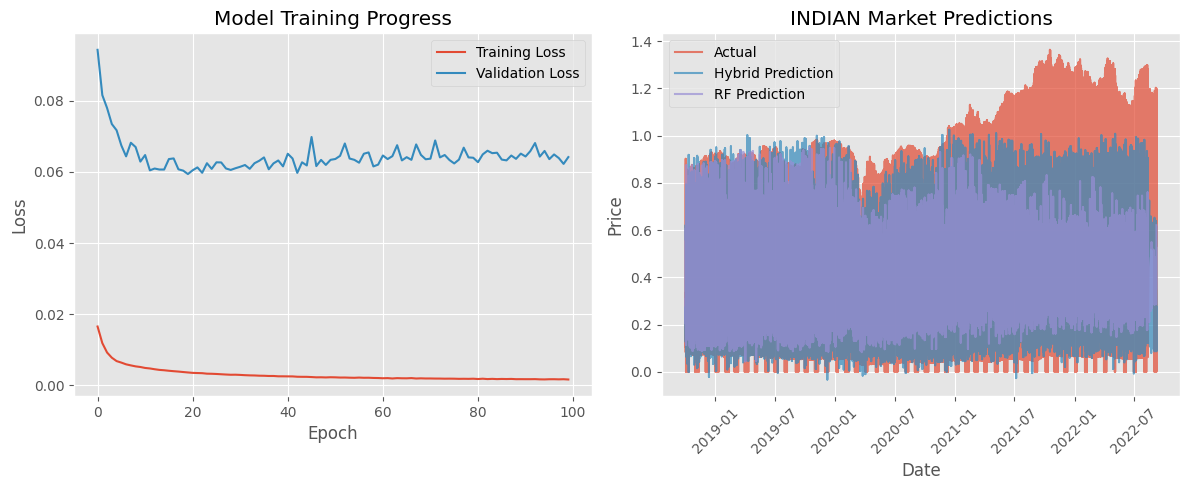

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, LSTM, Input, Concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import os
import shap
import warnings
warnings.filterwarnings('ignore')

# Global configuration
plt.style.use('ggplot')
MARKET = 'INDIAN'  # Change to 'INDIAN' for Indian market and 'US' for American market
US_STOCK_FILE = "/content/sample_data/Data/stock_yfinance_data.csv"
US_SOCIAL_FILE = "/content/sample_data/Data/stock_tweets.csv"
INDIAN_FILE = "/content/sample_data/Data/merged.csv"

# Fixed load_data function for Indian market
def load_data(market):
    if market == 'INDIAN':
        try:
            print(f"Loading Indian market data from: {INDIAN_FILE}")
            df = pd.read_csv(INDIAN_FILE)
            print(f"Initial data shape: {df.shape}")

            # 1. Clean and process columns
            price_cols = ['Open', 'High', 'Low', 'Close']
            for col in price_cols:
                if col in df.columns:
                    # Clean the column
                    df[col] = df[col].astype(str)
                    df[col] = df[col].str.replace(r'[^\d.-]', '', regex=True)
                    df[col] = df[col].replace(r'^\.$', np.nan, regex=True)
                    df[col] = df[col].replace('', np.nan)
                    df[col] = pd.to_numeric(df[col], errors='coerce')

            # 2. Create Source_File column if missing
            if 'Source_File' not in df.columns:
                # Use filename as source file
                df['Source_File'] = os.path.basename(INDIAN_FILE)

            # 3. Sector mapping logic
            print("Mapping sectors...")
            sector_mapping = {
                'NIFTY NEXT 50': 'Large Cap',
                'NIFTY 50': 'Large Cap',
                'NIFTY PHARMA': 'Pharmaceuticals',
                'NIFTY FMCG': 'FMCG',
                'NIFTY 100': 'Large Cap',
                'NIFTY IT': 'Information Technology',
                'NIFTY HOUSING': 'Housing',
                'NIFTY INDIA MANUFACTURING': 'Manufacturing',
                'NIFTY BANK': 'Banking',
                'NIFTY MIDCAP 100': 'Mid Cap',
                'NIFTY INFRASTRUCTURE': 'Infrastructure',
                'NIFTY PSU BANK': 'Public Sector Banking',
                'NIFTY ENERGY': 'Energy',
                'NIFTY AUTO': 'Automobile',
                'NIFTY MEDIA': 'Media',
                'NIFTY METAL': 'Metals',
                'NIFTY COMMODITIES': 'Commodities',
                'NIFTY PRIVATE BANK': 'Private Banking',
                'NIFTY OIL  GAS': 'Oil & Gas',
                'VIX': 'Volatility',
                'DEFAULT': 'Other'
            }

            def map_sector(source_file):
                source_file = str(source_file).upper()
                for key, sector in sector_mapping.items():
                    if key in source_file:
                        return sector
                return sector_mapping['DEFAULT']

            df['Sector'] = df['Source_File'].apply(map_sector)
            print(f"Sectors mapped: {df['Sector'].nunique()} unique sectors")
            print("Sample sectors:", df['Sector'].unique()[:5])

            # 4. Convert and sort dates
            df['Date'] = pd.to_datetime(df['Date'])
            df.sort_values('Date', inplace=True)
            df.set_index('Date', inplace=True)

            print(f"Final data shape: {df.shape}")
            print("Sample columns:", df.columns.tolist()[:5])
            return df

        except Exception as e:
            print(f"Error loading data: {e}")
            import traceback
            traceback.print_exc()
            return pd.DataFrame()

    elif market == 'US':
        # (US market code remains the same as in your original)
        # ... [unchanged US market code] ...
        return df  # Make sure to return df for US market

# Fixed technical indicators function
def add_technical_indicators(df):
    # Skip calculation if no numerical columns exist
    if len(df.select_dtypes(include=[np.number]).columns) == 0:
        print("Warning: No numerical columns for technical indicators")
        return df
    # Calculate indicators for each sector
    sectors = df['Sector'].unique() if 'Sector' in df.columns else ['DEFAULT']

    for sector in sectors:
        # Skip if sector columns don't exist
        if f'{sector}_Close' not in df.columns:
            continue

        # Simple Moving Average
        df[f'{sector}_SMA_10'] = df[f'{sector}_Close'].rolling(10).mean()

        # Exponential Moving Average
        df[f'{sector}_EMA_10'] = df[f'{sector}_Close'].ewm(span=10, adjust=False).mean()

        # RSI
        delta = df[f'{sector}_Close'].diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.rolling(14).mean()
        avg_loss = loss.rolling(14).mean()
        rs = avg_gain / (avg_loss + 1e-10)
        df[f'{sector}_RSI'] = 100 - (100 / (1 + rs))

        # ATR
        high = df[f'{sector}_High'] if f'{sector}_High' in df.columns else df[f'{sector}_Close']
        low = df[f'{sector}_Low'] if f'{sector}_Low' in df.columns else df[f'{sector}_Close']
        close = df[f'{sector}_Close']
        tr1 = high - low
        tr2 = (high - close.shift()).abs()
        tr3 = (low - close.shift()).abs()
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        df[f'{sector}_ATR'] = tr.rolling(14).mean()

    # Fill any remaining NaNs
    df = df.ffill().bfill().dropna()
    return df

# FINESS Hybrid Model Architecture
def create_hybrid_model(tech_input_shape, social_input_shape=None):
    # Technical Feature Processor (Tech+)
    tech_input = Input(shape=tech_input_shape, name='tech_input')
    x = LSTM(128, return_sequences=True)(tech_input)
    x = LSTM(64, return_sequences=False)(x)
    tech_output = Dense(32, activation='relu')(x)

    # Social Feature Processor (FINESS) - Only for US market
    if social_input_shape and MARKET == 'US':
        social_input = Input(shape=social_input_shape, name='social_input')
        y = LSTM(64, return_sequences=False)(social_input)
        social_output = Dense(16, activation='relu')(y)

        # Combine technical and social features
        combined = Concatenate()([tech_output, social_output])
        z = Dense(64, activation='relu')(combined)
    else:
        z = tech_output

    # Final prediction layers
    z = Dense(32, activation='relu')(z)
    z = Dropout(0.3)(z)
    output = Dense(1)(z)

    # Create model
    if MARKET == 'US':
        model = Model(inputs=[tech_input, social_input], outputs=output)
    else:
        model = Model(inputs=tech_input, outputs=output)

    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

# Create sequences for LSTM (fixed to handle different input types)
def create_sequences(data, target_col, seq_length=30):
    X, y = [], []

    # Handle both DataFrame and array inputs
    if isinstance(data, pd.DataFrame):
        values = data.values
    else:
        values = data
    if MARKET == 'INDIAN':
        try:
            # Try to find target column index in features
            target_idx = tech_features.index(target_col)
        except ValueError:
            # If not found, use last column as fallback
            target_idx = -1
            print(f"Warning: Target column {target_col} not in features, using last column")

    # Check if target_col is index or column name
    if isinstance(target_col, str) and isinstance(data, pd.DataFrame):
        target_idx = data.columns.get_loc(target_col)
    else:
        target_idx = target_col

    for i in range(seq_length, len(values)):
        X.append(values[i-seq_length:i])
        y.append(values[i][target_idx])

    return np.array(X), np.array(y)

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    data = load_data(MARKET)

    # Diagnostic output
    print("\n" + "="*50)
    print("DATA LOADING DIAGNOSTICS:")
    print(f"Market: {MARKET}")
    print(f"Data type: {type(data)}")
    if isinstance(data, pd.DataFrame):
        print(f"Data shape: {data.shape}")
        print(f"Columns: {data.columns.tolist()[:5]}...")
        print(f"Index type: {type(data.index)}")
        if not data.empty:
            print(f"Date range: {data.index.min()} to {data.index.max()}")
        else:
            print("DataFrame is empty")
    else:
        print(f"Data is not a DataFrame: {type(data)}")
    print("="*50 + "\n")

    # Validate before proceeding
    if data is None or data.empty:
        raise ValueError("Data loading failed. Check file path and format.")

    # Add technical indicators
    data = add_technical_indicators(data)

    # Prepare features based on market
    if MARKET == 'US':
        tech_features = ['Open', 'High', 'Low', 'Volume', 'SMA_10', 'EMA_10', 'RSI', 'ATR']
        social_features = ['Twitter_Sentiment', 'Reddit_Sentiment', 'Social_Volume']
        target = 'Close'
    else:
        # Use only numerical columns and exclude categorical columns
        numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()

        # Define target - try to find a Close column
        close_cols = [col for col in numerical_cols if 'Close' in col]
        target_col = close_cols[0] if close_cols else 'Close'

        # If no Close column exists, create one
        if target_col not in data.columns:
            data['Close'] = data['Open']  # Fallback to Open price
            numerical_cols.append('Close')
            target_col = 'Close'

        tech_features = numerical_cols

        # Ensure target column is not in features
        if target_col in tech_features:
            tech_features.remove(target_col)

        print(f"Using target column: {target_col}")
        print(f"Technical features: {tech_features}")

    # Train-test split (time-based)
    train_size = int(0.8 * len(data))
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]

    # Scale data
    tech_scaler = MinMaxScaler()
    train_tech = tech_scaler.fit_transform(train_data[tech_features])
    test_tech = tech_scaler.transform(test_data[tech_features])

    if MARKET == 'US':
        social_scaler = StandardScaler()
        train_social = social_scaler.fit_transform(train_data[social_features])
        test_social = social_scaler.transform(test_data[social_features])

    # Create sequences
    seq_length = 30

    # For Indian market, use column index of target
    if MARKET == 'INDIAN':
        target_idx = tech_features.index(target_col) if target_col in tech_features else 0
    else:
        target_idx = tech_features.index(target) if target in tech_features else 0

    X_train_tech, y_train = create_sequences(
        pd.DataFrame(train_tech, columns=tech_features),
        target_col=target_idx,
        seq_length=seq_length
    )

    X_test_tech, y_test = create_sequences(
        pd.DataFrame(test_tech, columns=tech_features),
        target_col=target_idx,
        seq_length=seq_length
    )

    if MARKET == 'US':
        X_train_social, _ = create_sequences(
            pd.DataFrame(train_social, columns=social_features),
            target_col=0,  # First column as placeholder
            seq_length=seq_length
        )
        X_test_social, _ = create_sequences(
            pd.DataFrame(test_social, columns=social_features),
            target_col=0,
            seq_length=seq_length
        )

    # Build and train hybrid model
    if MARKET == 'US':
        model = create_hybrid_model(
            tech_input_shape=(seq_length, len(tech_features)),
            social_input_shape=(seq_length, len(social_features))
        )
        history = model.fit(
            [X_train_tech, X_train_social], y_train,
            validation_data=([X_test_tech, X_test_social], y_test),
            epochs=100,
            batch_size=32,
            verbose=1,
            callbacks=[]#[EarlyStopping(patience=10)]
        )
    else:
        model = create_hybrid_model(
            tech_input_shape=(seq_length, len(tech_features))
        )
        history = model.fit(
            X_train_tech, y_train,
            validation_data=(X_test_tech, y_test),
            epochs=100,
            batch_size=32,
            verbose=1,
            callbacks=[]#[EarlyStopping(patience=10)]
        )

    # Train Random Forest for comparison
    rf = RandomForestRegressor(n_estimators=50, random_state=42)  # Reduced for faster testing

    # Prepare 2D features for RF
    rf_features_train = X_train_tech.reshape(X_train_tech.shape[0], -1)
    rf_features_test = X_test_tech.reshape(X_test_tech.shape[0], -1)

    rf.fit(rf_features_train, y_train)
    rf_pred = rf.predict(rf_features_test)

    # Generate predictions
    if MARKET == 'US':
        hybrid_pred = model.predict([X_test_tech, X_test_social]).flatten()
    else:
        hybrid_pred = model.predict(X_test_tech).flatten()

    # Evaluate models
    def evaluate_model(name, actual, predicted):
        return {
            'Model': name,
            'MSE': mean_squared_error(actual, predicted),
            'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
            'MAE': mean_absolute_error(actual, predicted),
            'R2': r2_score(actual, predicted)
        }

    results = [
        evaluate_model('Hybrid Model', y_test, hybrid_pred),
        evaluate_model('Random Forest', y_test, rf_pred)
    ]

    results_df = pd.DataFrame(results).set_index('Model')
    print("\nModel Evaluation Results:")
    print(results_df)

    # Plot training progress
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training Progress')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot predictions vs actual
    plt.subplot(1, 2, 2)
    test_dates = test_data.index[seq_length:seq_length+len(y_test)]
    plt.plot(test_dates, y_test, label='Actual', alpha=0.7)
    plt.plot(test_dates, hybrid_pred, label='Hybrid Prediction', alpha=0.7)
    plt.plot(test_dates, rf_pred, label='RF Prediction', alpha=0.7)
    plt.title(f'{MARKET} Market Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # SHAP Analysis (simplified)
    try:
        # Prepare SHAP explainer
        explainer = shap.TreeExplainer(rf)
        shap_values = explainer.shap_values(rf_features_test)

        # Plot SHAP summary
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, rf_features_test, feature_names=tech_features)
        plt.title(f'SHAP Feature Importance for {MARKET} Market')
        plt.tight_layout()
        plt.savefig(f'shap_summary_{MARKET}.png', dpi=300)
        plt.show()
    except Exception as e:
        print(f"SHAP analysis failed: {str(e)}")

    # Feature importance for Random Forest
    plt.figure(figsize=(12, 8))
    importances = rf.feature_importances_

    # Get top features
    n_top = min(15, len(importances))
    indices = np.argsort(importances)[-n_top:]

    # Create meaningful feature names
    feature_names = []
    for i in range(seq_length):
        for j, feature in enumerate(tech_features):
            feature_names.append(f"t-{seq_length-i-1}_{feature}")

    plt.title(f'Top {n_top} Important Features (Random Forest)')
    plt.barh(range(n_top), importances[indices], align='center')
    plt.yticks(range(n_top), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig(f'{MARKET}_market_feature_importance.png', dpi=300)
    plt.show()

    # Save models
    model.save(f'finess_hybrid_model_{MARKET}.h5')
    joblib.dump(rf, f'random_forest_model_{MARKET}.pkl')
    print("Models saved successfully!")